In [1]:
# standart libs
import sys
import random
import copy
from operator import itemgetter
from PIL import Image
import time


# 3rd party libs
import pandas as pd
import numpy as np
import gempy as gp
import matplotlib.pyplot as plt
import scipy.stats as ss
from skimage import measure
from matplotlib import gridspec


# local
import functions.realization_setup as real_setup
import functions.realization_run as real_run
import functions.post_processing as post_pro
import functions.uq_runs as uq_runs

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


[]

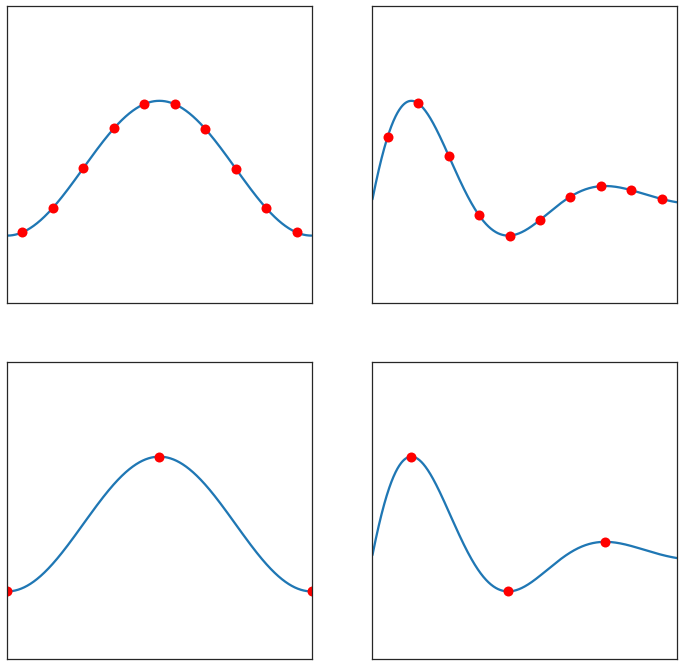

In [2]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, constrained_layout=False, figsize=(12, 12))
markersize=10

# create basic form
xsim = np.linspace(0, 2 * np.pi, 1000)
ysim = np.cos(xsim) * (-1)
# rescale
xsim = (xsim / (2 * np.pi)) * 1000
ysim = (ysim + 1) * 250 + 250

# create basic form
xcom = np.linspace(0, np.pi, 1000)
ycom = np.exp(-xcom) * np.sin(np.pi * xcom)
# rescale
xcom = (xcom / np.pi) * 1000
ycom -= np.min(ycom)
ycom = (ycom / np.max(ycom)) * 500 + 250

# n-points
def n_points(n, xvals, yvals):
    st = int(xvals.shape[0] / n)
    ss = int(st/2)
    return (xvals[ss::st], yvals[ss::st])

# sample 5 points
xsim_n, ysim_n = n_points(10, xsim, ysim)
xcom_n, ycom_n = n_points(10, xcom, ycom)

# extrema
def extrema(xvals, yvals):
    b0 = (yvals[1:] - yvals[:-1]) > 0
    b1 = b0[1:] ^ b0[:-1]   
    return (xvals[1:-1][b1], yvals[1:-1][b1])

# sample extrema
xsim_ext, ysim_ext = extrema(xsim, ysim)
xcom_ext, ycom_ext = extrema(xcom, ycom)

# ax0
ax0.plot(xsim, ysim)
ax0.plot(xsim_n, ysim_n, "o", c='red', markersize=markersize)
ax0.set_xlim([0,1000])
ax0.set_ylim([0,1100])
ax0.set_yticklabels([])
ax0.set_xticklabels([])

# ax1
ax1.plot(xcom, ycom)
ax1.plot(xcom_n, ycom_n, "o", c='red', markersize=markersize)
ax1.set_xlim([0,1000])
ax1.set_ylim([0,1100])
ax1.set_yticklabels([])
ax1.set_xticklabels([])

# ax2
ax2.plot(xsim, ysim)
ax2.plot(xsim_ext, ysim_ext, "o", c='red', markersize=markersize)
ax2.plot([0, 1000], [250, 250], "o", c='red', markersize=markersize)
ax2.set_xlim([0,1000])
ax2.set_ylim([0,1100])
ax2.set_yticklabels([])
ax2.set_xticklabels([])

# ax3
ax3.plot(xcom, ycom)
ax3.plot(xcom_ext, ycom_ext, "o", c='red', markersize=markersize)
ax3.set_xlim([0,1000])
ax3.set_ylim([0,1100])
ax3.set_yticklabels([])
ax3.set_xticklabels([])

In [3]:
# instantiate the geo_model
geo_model = gp.create_model("GeoModel")

# defautl data
geo_model = gp.init_data(
    geo_model,
    extent=[0, 1, 0, 1, 0, 1],
    resolution=[1, 1, 1]
)

# compile theno function
gp.set_interpolation_data(
    geo_model,
    compile_theano=True,
    theano_optimizer='fast_run',
)

Active grids: ['regular']
Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_run
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                     values
range              1.73205
$C_o$            0.0714286
drift equations        [3]


In [4]:
def compare(xline, yline, A):
    """Compared the drawn line with the resutling interpolation.
    Assumes that (including matrix shifting) the shape of the extracted
    line (boolen matrix) equals the shape and coordinates of the drawn
    line.
    """
    # create coordinates to extract from
    _x = np.arange(0, 998, 1)
    X, Y = np.meshgrid(_x, _x)
    xcorr, ycoor = X[A], Y[A]
    # extract the corresponding line point
    # works as boolen matrix idx and line coor are interchangeable
    # !nomralized setting! No generic approach!
    xerr, yerr = xline[xcorr], yline[xcorr] 
    # return
    return (xcorr, ycoor, xerr, yerr) 

def sort_xy(x, y):
    a = np.argsort(x)
    return x[a], y[a]

In [5]:
def comp_npoints(xline, yline, n, simp):
    # setup the model input
    extent = [0,1000,0,1000,0,1000]
    section = {
        'p1': [0, 500],
        'p2': [1000, 500],
        'resolution': [1000 - 2, 1000 - 1] # to fit plot shape
    }
    series_df = pd.DataFrame(columns=['name', 'isfault', 'order_series'])
    series_df.loc[0] = { 'order_series': 0, 'name': 'Strat_Series', 'isfault': False }
    xsim_n, ysim_n = n_points(n, xline, yline)
    surfaces_df = pd.DataFrame(columns=['name', 'serie', 'order_surface'])
    surfaces_df.loc[0] = { 'name': 'basement', 'serie': 'Basement_Series', 'order_surface': 0 }
    surfaces_df.loc[1] = { 'name': 'rock1', 'serie': 'Strat_Series', 'order_surface': 1 }
    surface_points = pd.DataFrame(columns=['X', 'Y', 'Z', 'surface'])
    surface_points.X = xsim_n
    surface_points.Y = 500
    surface_points.Z = ysim_n
    surface_points.surface = 'rock1'
    orientations = pd.DataFrame(columns=['X', 'Y', 'Z', 'dip', 'azimuth', 'polarity', 'formation'])
    if simp:
        orientations.loc[0]=[500, 501, 1000, 0, 90, 1, 'rock1']
    else:
        orientations.loc[0]=[1000, 501, 250, 0, 90, 1, 'rock1']
    # setup the geo-model & compute
    real_setup.setup_realization(
            geo_model=geo_model,
            geo_model_extent=extent,
            section=section,
            series_df=series_df,
            surfaces_df=surfaces_df,
            surface_points_original_df=surface_points,
            orientations_original_df=orientations
    )
    t0 = time.time()
    if real_run.check_setup_single_realization(geo_model):
        solution = gp.compute_model(model=geo_model, sort_surfaces=False)
    t1 = time.time()
    Bx = post_pro.compute_boolean_matrix_for_section_surface_top(geo_model)
    A = Bx['0-1']
    # apply
    xcoor, ycoor, xerr, yerr = compare(xline, yline, A)
    # calc err
    yerr = ycoor - yerr
    # sort
    xcoor_sorted, ycoor_sorted = sort_xy(xcoor, ycoor)
    xcoor_sorted, yerr_sorted = sort_xy(x=xcoor, y=yerr)
    #plot
    #plt.plot(xcoor_sorted, ycoor_sorted, 'o', c='steelblue')
    #plt.plot(xline, yline, '-', c='orange')
    #plt.fill_between(xcoor_sorted, 0, yerr_sorted, color='red')
    err_abs = np.sum(np.abs(yerr_sorted))
    secs = t1 - t0
    cx = {
        'xcoor_sorted': xcoor_sorted,
        'ycoor_sorted': ycoor_sorted,
        'yerr_sorted': yerr_sorted,
        'err_abs': err_abs,
        'secs': secs
    }
    return cx

In [6]:
def comp_extrema(xline, yline, simp):
    # setup the model input
    extent = [0,1000,0,1000,0,1000]
    section = {
        'p1': [0, 500],
        'p2': [1000, 500],
        'resolution': [1000 - 2, 1000 - 1] # to fit plot shape
    }
    series_df = pd.DataFrame(columns=['name', 'isfault', 'order_series'])
    series_df.loc[0] = { 'order_series': 0, 'name': 'Strat_Series', 'isfault': False }
    xsim_ext, ysim_ext = extrema(xline, yline)
    surfaces_df = pd.DataFrame(columns=['name', 'serie', 'order_surface'])
    surfaces_df.loc[0] = { 'name': 'basement', 'serie': 'Basement_Series', 'order_surface': 0 }
    surfaces_df.loc[1] = { 'name': 'rock1', 'serie': 'Strat_Series', 'order_surface': 1 }
    surface_points = pd.DataFrame(columns=['X', 'Y', 'Z', 'surface'])
    if simp:
        surface_points.X = np.array([0, 500, 1000])
        surface_points.Y = 500
        surface_points.Z = np.array([250, 750, 250])
    else:
        surface_points.X = xsim_ext
        surface_points.Y = 500
        surface_points.Z = ysim_ext    
    surface_points.surface = 'rock1'
    orientations = pd.DataFrame(columns=['X', 'Y', 'Z', 'dip', 'azimuth', 'polarity', 'formation'])
    if simp:
        orientations.loc[0]=[500, 501, 750, 0, 90, 1, 'rock1']
    else:
        orientations.loc[0]=[1000, 501, 373, 0, 90, 1, 'rock1']
    # setup the geo-model & compute
    real_setup.setup_realization(
            geo_model=geo_model,
            geo_model_extent=extent,
            section=section,
            series_df=series_df,
            surfaces_df=surfaces_df,
            surface_points_original_df=surface_points,
            orientations_original_df=orientations
    )
    if real_run.check_setup_single_realization(geo_model):
        solution = gp.compute_model(model=geo_model, sort_surfaces=False)
    Bx = post_pro.compute_boolean_matrix_for_section_surface_top(geo_model)
    A = Bx['0-1']
    # apply
    xcoor, ycoor, xerr, yerr = compare(xline, yline, A)
    # calc err
    yerr = ycoor - yerr
    # sort
    xcoor_sorted, ycoor_sorted = sort_xy(xcoor, ycoor)
    xcoor_sorted, yerr_sorted = sort_xy(x=xcoor, y=yerr)
    #plot
    #plt.plot(xcoor_sorted, ycoor_sorted, 'o', c='steelblue')
    #plt.plot(xline, yline, '-', c='orange')
    #plt.fill_between(xcoor_sorted, 0, yerr_sorted, color='red')
    #plt.plot(geo_model.surface_points.df.X, geo_model.surface_points.df.Z, 'o', c='red')
    err_abs = np.sum(np.abs(yerr_sorted))
    cx = {
        'xcoor_sorted': xcoor_sorted,
        'ycoor_sorted': ycoor_sorted,
        'yerr_sorted': yerr_sorted,
        'err_abs': err_abs,
        
    }
    return cx

Active grids: ['regular']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
HOTFIX in update_surfaces()
Run realizations setup checks until stable workflow.
Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
Run realizations setup checks until stable workflow.
Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
Run realizations setup checks until stable workflow.
Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
Run realizations setup checks until stable workflow.


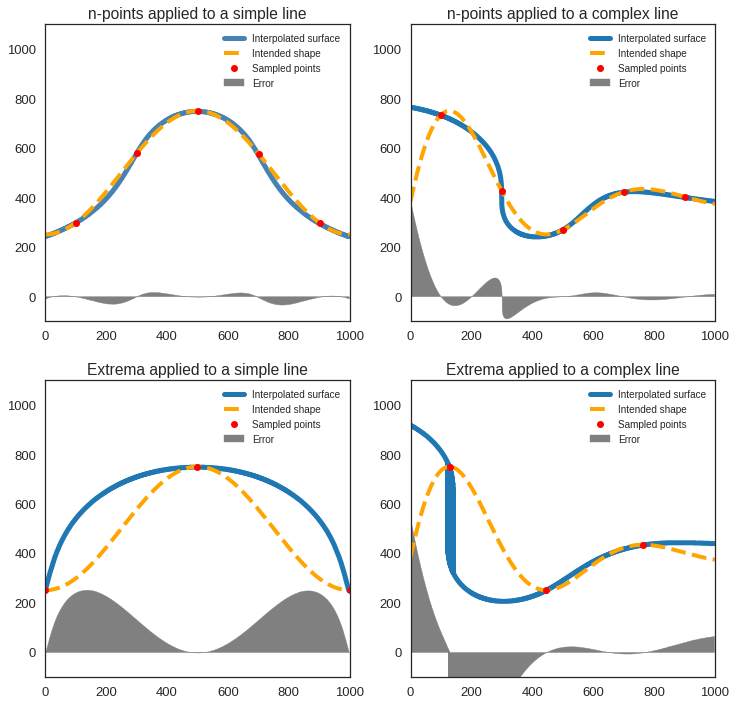

In [7]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, constrained_layout=False, figsize=(12, 12))
markersize=7
linewidth = 5

# create basic form
xsim = np.linspace(0, 2 * np.pi, 1000)
ysim = np.cos(xsim) * (-1)
# rescale
xsim = (xsim / (2 * np.pi)) * 1000
ysim = (ysim + 1) * 250 + 250

# create basic form
xcom = np.linspace(0, np.pi, 1000)
ycom = np.exp(-xcom) * np.sin(np.pi * xcom)
# rescale
xcom = (xcom / np.pi) * 1000
ycom -= np.min(ycom)
ycom = (ycom / np.max(ycom)) * 500 + 250

# n-points
def n_points(n, xvals, yvals):
    st = int(xvals.shape[0] / n)
    ss = int(st/2)
    return (xvals[ss::st], yvals[ss::st])

# sample 5 points

# extrema
def extrema(xvals, yvals):
    b0 = (yvals[1:] - yvals[:-1]) > 0
    b1 = b0[1:] ^ b0[:-1]   
    return (xvals[1:-1][b1], yvals[1:-1][b1])

# ax0
cx0 = comp_npoints(xsim, ysim, n=5, simp=True)
xsim_n, ysim_n = n_points(5, xsim, ysim)
ax0.plot(cx0['xcoor_sorted'], cx0['ycoor_sorted'], '-', c='steelblue', linewidth=linewidth, label='Interpolated surface')
ax0.plot(xsim, ysim, '--', c='orange', linewidth=linewidth - 1, label='Intended shape')
ax0.plot(xsim_n, ysim_n, "o", c='red', markersize=markersize, label='Sampled points')
ax0.fill_between(cx0['xcoor_sorted'], 0, cx0['yerr_sorted'], color='grey', label='Error')
ax0.set_xlim([0,1000])
ax0.set_ylim([-100,1100])
#ax0.set_yticklabels([])
#ax0.set_xticklabels([])
ax0.legend(loc='upper right', fontsize=10)
ax0.set_title('n-points applied to a simple line')

# ax1
cx1 = comp_npoints(xcom, ycom, n=5, simp=False)
xcom_n, ycom_n = n_points(5, xcom, ycom)
ax1.plot(cx1['xcoor_sorted'], cx1['ycoor_sorted'], '-', linewidth=linewidth, label='Interpolated surface')
ax1.plot(xcom, ycom, '--', c='orange', linewidth=linewidth - 1, label='Intended shape')
ax1.plot(xcom_n, ycom_n, "o", c='red', markersize=markersize, label='Sampled points')
ax1.fill_between(cx1['xcoor_sorted'], 0, cx1['yerr_sorted'], color='grey', label='Error')
ax1.set_xlim([0,1000])
ax1.set_ylim([-100,1100])
#ax1.set_yticklabels([])
#ax1.set_xticklabels([])
ax1.legend(loc='upper right', fontsize=10)
ax1.set_title('n-points applied to a complex line')

# ax2
cx2 = comp_extrema(xsim, ysim, simp=True)
xsim_ext, ysim_ext = extrema(xsim, ysim)
ax2.plot(cx2['xcoor_sorted'], cx2['ycoor_sorted'], linewidth=linewidth, label='Interpolated surface')
ax2.plot(xsim, ysim, '--', c='orange', linewidth=linewidth - 1, label='Intended shape')
ax2.plot(xsim_ext, ysim_ext, "o", c='red', markersize=markersize, label='Sampled points')
ax2.plot([0,1000], [250,250], "o", c='red', markersize=markersize)
ax2.fill_between(cx2['xcoor_sorted'], 0, cx2['yerr_sorted'], color='grey', label='Error')
ax2.set_xlim([0,1000])
ax2.set_ylim([-100,1100])
#ax2.set_yticklabels([])
#ax2.set_xticklabels([])
ax2.legend(loc='upper right', fontsize=10)
ax2.set_title('Extrema applied to a simple line')


# ax3
cx3 = comp_extrema(xcom, ycom, simp=False)
xcom_ext, ycom_ext = extrema(xcom, ycom)
ax3.plot(cx3['xcoor_sorted'], cx3['ycoor_sorted'], linewidth=linewidth, label='Interpolated surface')
ax3.plot(xcom, ycom, '--', c='orange', linewidth=linewidth - 1, label='Intended shape')
ax3.plot(xcom_ext, ycom_ext, "o", c='red', markersize=markersize, label='Sampled points')
ax3.fill_between(cx3['xcoor_sorted'], 0, cx3['yerr_sorted'], color='grey', label='Error')
ax3.set_xlim([0,1000])
ax3.set_ylim([-100,1100])
#ax3.set_yticklabels([])
#ax3.set_xticklabels([])
ax3.legend(loc='upper right', fontsize=10)
ax3.set_title('Extrema applied to a complex line')

fig.savefig('../document/figures/results_parameterization_0.png')
plt.show()

In [8]:
err = comp_npoints(xsim, ysim, n=5, simp=True)
err['secs']

Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
Run realizations setup checks until stable workflow.


2.7953624725341797

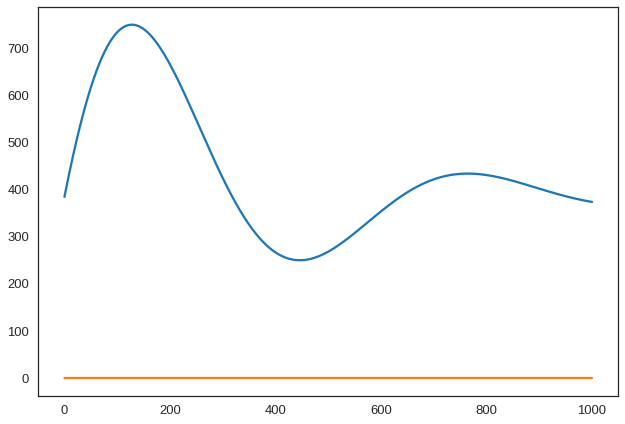

In [12]:
# create basic form
xcom = np.linspace(0, np.pi, 1000)
ycom = np.exp(-xcom) * np.sin(np.pi * xcom)
# derivative: −e−x(sin(πx)−πcos(πx)
# rescale
xcom = (xcom / np.pi) * 1000
ycom -= np.min(ycom)
ycom = (ycom / np.max(ycom)) * 500 + 250
dys = np.exp(-xcom) * np.sin(np.pi * xcom) * -np.pi * np.cos(np.pi * xcom)

plt.plot(xcom, ycom)
plt.plot(xcom, dys)

In [11]:
dys

array([-0.00000000e+000, -3.63079880e-003, -2.66866695e-003,
       -1.47109971e-003, -7.20827905e-004, -3.31120921e-004,
       -1.46018256e-004, -6.26018994e-005, -2.62910112e-005,
       -1.08688080e-005, -4.43767795e-006, -1.79373842e-006,
       -7.19039222e-007, -2.86229153e-007, -1.13264025e-007,
       -4.45905597e-008, -1.74764661e-008, -6.82273950e-009,
       -2.65431748e-009, -1.02943449e-009, -3.98138448e-010,
       -1.53594860e-010, -5.91190691e-011, -2.27077713e-011,
       -8.70550433e-012, -3.33160089e-012, -1.27294846e-012,
       -4.85646194e-013, -1.85023653e-013, -7.04002902e-014,
       -2.67546438e-014, -1.01562951e-014, -3.85135477e-015,
       -1.45902134e-015, -5.52210932e-016, -2.08817421e-016,
       -7.88983647e-017, -2.97871023e-017, -1.12373879e-017,
       -4.23638902e-018, -1.59600730e-018, -6.00892236e-019,
       -2.26096624e-019, -8.50235994e-020, -3.19553913e-020,
       -1.20037957e-020, -4.50684591e-021, -1.69128077e-021,
       -6.34389865e-022,

In [1]:
def comp_npoints_2(xline, yline, n, simp):
    # setup the model input
    extent = [0,1000,0,1000,0,1000]
    section = {
        'p1': [0, 500],
        'p2': [1000, 500],
        'resolution': [1000 - 2, 1000 - 1] # to fit plot shape
    }
    series_df = pd.DataFrame(columns=['name', 'isfault', 'order_series'])
    series_df.loc[0] = { 'order_series': 0, 'name': 'Strat_Series', 'isfault': False }
    xsim_n, ysim_n = n_points(n, xline, yline)
    surfaces_df = pd.DataFrame(columns=['name', 'serie', 'order_surface'])
    surfaces_df.loc[0] = { 'name': 'basement', 'serie': 'Basement_Series', 'order_surface': 0 }
    surfaces_df.loc[1] = { 'name': 'rock1', 'serie': 'Strat_Series', 'order_surface': 1 }
    surface_points = pd.DataFrame(columns=['X', 'Y', 'Z', 'surface'])
    surface_points.X = xsim_n
    surface_points.Y = 500
    surface_points.Z = ysim_n
    surface_points.surface = 'rock1'
    orientations = pd.DataFrame(columns=['X', 'Y', 'Z', 'dip', 'azimuth', 'polarity', 'formation'])
    if simp:
        orientations.loc[0]=[500, 501, 1000, 0, 90, 1, 'rock1']
    else:
        orientations.loc[0]=[1000, 501, 250, 0, 90, 1, 'rock1']
    # setup the geo-model & compute
    real_setup.setup_realization(
            geo_model=geo_model,
            geo_model_extent=extent,
            section=section,
            series_df=series_df,
            surfaces_df=surfaces_df,
            surface_points_original_df=surface_points,
            orientations_original_df=orientations
    )
    t0 = time.time()
    if real_run.check_setup_single_realization(geo_model):
        solution = gp.compute_model(model=geo_model, sort_surfaces=False)
    t1 = time.time()
    Bx = post_pro.compute_boolean_matrix_for_section_surface_top(geo_model)
    A = Bx['0-1']
    # apply
    xcoor, ycoor, xerr, yerr = compare(xline, yline, A)
    # calc err
    yerr = ycoor - yerr
    # sort
    xcoor_sorted, ycoor_sorted = sort_xy(xcoor, ycoor)
    xcoor_sorted, yerr_sorted = sort_xy(x=xcoor, y=yerr)
    #plot
    #plt.plot(xcoor_sorted, ycoor_sorted, 'o', c='steelblue')
    #plt.plot(xline, yline, '-', c='orange')
    #plt.fill_between(xcoor_sorted, 0, yerr_sorted, color='red')
    err_abs = np.sum(np.abs(yerr_sorted))
    secs = t1 - t0
    cx = {
        'xcoor_sorted': xcoor_sorted,
        'ycoor_sorted': ycoor_sorted,
        'yerr_sorted': yerr_sorted,
        'err_abs': err_abs,
        'secs': secs
    }
    return cx

In [ ]:
fig, ((ax0, ax1)) = plt.subplots(nrows=2, ncols=2, constrained_layout=False, figsize=(12, 12))
markersize=7
linewidth = 5

# create basic form
xsim = np.linspace(0, 2 * np.pi, 1000)
ysim = np.cos(xsim) * (-1)
# rescale
xsim = (xsim / (2 * np.pi)) * 1000
ysim = (ysim + 1) * 250 + 250

# create basic form
xcom = np.linspace(0, np.pi, 1000)
ycom = np.exp(-xcom) * np.sin(np.pi * xcom)
# rescale
xcom = (xcom / np.pi) * 1000
ycom -= np.min(ycom)
ycom = (ycom / np.max(ycom)) * 500 + 250

# n-points
def n_points(n, xvals, yvals):
    st = int(xvals.shape[0] / n)
    ss = int(st/2)
    return (xvals[ss::st], yvals[ss::st])

# sample 5 points

# extrema
def extrema(xvals, yvals):
    b0 = (yvals[1:] - yvals[:-1]) > 0
    b1 = b0[1:] ^ b0[:-1]   
    return (xvals[1:-1][b1], yvals[1:-1][b1])

# ax0
cx0 = comp_npoints(xsim, ysim, n=5, simp=True)
xsim_n, ysim_n = n_points(5, xsim, ysim)
ax0.plot(cx0['xcoor_sorted'], cx0['ycoor_sorted'], '-', c='steelblue', linewidth=linewidth, label='Interpolated surface')
ax0.plot(xsim, ysim, '--', c='orange', linewidth=linewidth - 1, label='Intended shape')
ax0.plot(xsim_n, ysim_n, "o", c='red', markersize=markersize, label='Sampled points')
ax0.fill_between(cx0['xcoor_sorted'], 0, cx0['yerr_sorted'], color='grey', label='Error')
ax0.set_xlim([0,1000])
ax0.set_ylim([-100,1100])
#ax0.set_yticklabels([])
#ax0.set_xticklabels([])
ax0.legend(loc='upper right', fontsize=10)
ax0.set_title('n-points applied to a simple line')

# ax1
cx1 = comp_npoints(xcom, ycom, n=5, simp=False)
xcom_n, ycom_n = n_points(5, xcom, ycom)
ax1.plot(cx1['xcoor_sorted'], cx1['ycoor_sorted'], '-', linewidth=linewidth, label='Interpolated surface')
ax1.plot(xcom, ycom, '--', c='orange', linewidth=linewidth - 1, label='Intended shape')
ax1.plot(xcom_n, ycom_n, "o", c='red', markersize=markersize, label='Sampled points')
ax1.fill_between(cx1['xcoor_sorted'], 0, cx1['yerr_sorted'], color='grey', label='Error')
ax1.set_xlim([0,1000])
ax1.set_ylim([-100,1100])
#ax1.set_yticklabels([])
#ax1.set_xticklabels([])
ax1.legend(loc='upper right', fontsize=10)
ax1.set_title('n-points applied to a complex line')

fig.savefig('../document/figures/results_parameterization_1.png')
plt.show()